In [1]:
import migration_process as mp
import numpy as np

# 1. Modélisation Markovienne du problème

## 1.1 Rappel des consignes

Tout d'abord rappelons les consignes du problème avec les notations utilisées :
* On s'intéresse à $N$ stations Vélib qui contiennent respectivement $v_{i}$, $i\in⟦1;N⟧$ places.
Il y a $K\leq\sum_{i=1}^{N} v_{i}$ vélos dans le système.
* Des vélos se déplacent entre ces stations. Aucun vélo ne vient de l'extérieur, le système est donc **fermé**.
* On dispose des **paramètres** suivants :
 * $\forall i\in⟦1;N⟧$, $\mathbf{\lambda_{i}}$ **correspond à l'intensité des occurrences de demande de vélos à la station $\mathbf{i}$**.
 * $\forall i,j \in⟦1;N⟧$ tels que $i \neq j$, **le temps de trajet en vélo de la station $\mathbf{i}$ à la station $\mathbf{j}$** $\mathbf{\sim \mathcal{E}(\lambda_{ij})}$. Attention, $\lambda_{ij}\neq\lambda_{ji}$ en général.
 * une matrice de routage $P$ carrée de taille $N$, avec $\forall i, \sum_{j=1}^{N} p_{ij}=1$ (elle est donc stochastique) où $\forall i,j$, $\mathbf{p_{ij}}$ **est interprété comme la probabilité d'aller vers $\mathbf{j}$ pour un vélo qui part de la station $\mathbf{i}$**.
* On fait **hypothèses** suivantes :
 * Il n'y a **pas de boucle**, donc $\forall i,p_{ii}=0$
 * Si un vélo trouve la station d'arrivée $j$ pleine, on tire au sort une nouvelle station d'arrivée $k$ suivant $p_{jk}$ où $k \in⟦1;N⟧$ avec $k \neq j$
 * Si une requête à la station $i$ ne trouve pas de vélo, elle est perdue.
 
## 1.2 Modélisation

### 1.2.1 Espace d'états


On représente notre système par un ensemble de $N^{2}$ noeuds de deux types :
* $N$ noeuds représentent les stations de Vélib, ils sont de la forme $n_{ii}, \forall i\in⟦1;N⟧$. On considère que se sont des **files à 1 serveur**.
* $N(N-1)$ noeuds représentant les itinéraires d'une station vers une autre, ils sont de la forme $n_{ij}, \forall i,j\in⟦1;N⟧$ tels que $i \neq j$. On considère que se sont des **files à K serveurs**.





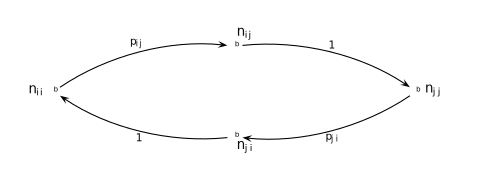

In [2]:
from IPython.core.display import SVG
SVG(filename='output.svg')

On s'inspire du chapitre *sur les colonies* issu du livre de Kelly pour la modélisation Markovienne. Une **colonie** est ici un noeuds de notre graphe, donc une station ou un trajet, et un **individu** est un vélo.

L'espace des état est $S=\left\{(n_{ij})_{i,j\in⟦1;N⟧} :  \sum_{i=1}^{N}\sum_{j=1}^{N}n_{ij}=K \wedge n_{ii}<v_{i}\right\} $.
Ainsi, chaque état est noté $n=(n_{11},n_{12},...,n_{NN})$ où $n_{ij}$ correspond au nombre de vélos dans l'état correspondant.

### 1.2.2 Générateur infinitésimal

Soit $n_{k}$ et $n_{l}$ deux noeuds distincts, $i,j\in⟦1;N⟧ \mbox{ avec } i \neq j$. Tout comme Kelly, on définit un opérateur $T_{kl}$ qui formalise soit : 
* le **départ d'un vélo d'une station** $n_{ii}$ **vers un itinéraire** $n_{ij}$. Dans ce cas, $n_{k}$ est une station et $k=(ii)$ ; $n_{l}$ est un itinéraire et $l=(ij)$.
* l'**arrivée d'un vélo dans une station** $n_{jj}$ **venant d'un itinéraire** $n_{ij}$, si $n_{jj} < v_{j}$. Dans ce cas, $n_{k}$ est un itinéraire et $k=(ij)$ ; $n_{l}$ est une station et $l=(jj)$.
* l'**arrivée d'un vélo dans un itinéraire** $n_{jm}$ **venant d'un itinéraire** $n_{ij}$, si $n_{jj} = v_{j}$. Dans ce cas, $n_{k}$ est un itinéraire et $k=(ij)$ ; $n_{l}$ est un itinéraire et $l=(jm)$.

$$
T_{kl}(n_{11},n_{12},...,n_{NN}) = \left\{
    \begin{array}{ll}
        T_{kl}(n_{11},n_{12},...,n_{k}-1,...,n_{l}+1,...,n_{NN}), \quad \mbox{ si } k=(ii), l=(ij) \mbox{ et }  i<j \\
        T_{kl}(n_{11},n_{12},...,n_{l}+1,...,n_{k}-1,...,n_{NN}), \quad \mbox{ si } k=(ii), l=(ij) \mbox{ et }  i>j \\
        T_{kl}(n_{11},n_{12},...,n_{k}-1,...,n_{l}+1,...,n_{NN}), \quad \mbox{ si } k=(ij), l=(jj) \mbox{ et }  i<j \mbox{ et } n_{jj} < v_{j}\\
        T_{kl}(n_{11},n_{12},...,n_{l}+1,...,n_{k}-1,...,n_{NN}), \quad \mbox{ si } k=(ij), l=(jj) \mbox{ et }  i>j \mbox{ et } n_{jj} < v_{j}\\
        T_{kl}(n_{11},n_{12},...,n_{k}-1,...,n_{l}+1,...,n_{NN}), \quad \mbox{ si } k=(ij), l=(jm) \mbox{ et }  i>j \mbox{ et } n_{jj} = v_{j}\\
        T_{kl}(n_{11},n_{12},...,n_{l}+1,...,n_{k}-1,...,n_{NN}), \quad \mbox{ si } k=(ij), l=(jm) \mbox{ et }  i<j \mbox{ et } n_{jj} = v_{j}\\
    \end{array}
\right.
$$

Définissons maintenant les taux de transition qui forment les coefficients du générateur infinitésimal, en utilisant la méthode proposée par Kelly.
Une transition ne peut avoir lieu qu'entre un état $n$ et un état $T_{kl}(n)$, où $n_{k}$ et $n_{l}$ sont deux noeuds distincts.
On considère que les taux de transition ont la forme suivante : $q(n,T_{kl}(n)) = \Lambda_{kl}\phi_{k}(n_{k})$. On distingue trois cas vus plus haut, **les  coefficient restants sont donc nuls** : 
* le **départ d'un vélo d'une station** $n_{ii}$ **vers un itinéraire** $n_{ij}$. Dans ce cas, $n_{k}$ est une station et $k=(ii)$ ; $n_{l}$ est un itinéraire et $l=(ij)$. On a : 
 * $\Lambda_{kl}=\lambda_{i}*p_{ij}$ où $\lambda_{i}$ et $p_{ij}$ sont donnés dans l'énoncé
 * $\phi_{k}(n_{k})=min(n_{ii},1)$ (1 car une station est une file à un serveur)
 * **donc** 
 $$
     q(n,T_{kl}(n)) = \lambda_{i}*p_{ij}*min(n_{i},1)
 $$
 
* l'**arrivée d'un vélo dans une station** $n_{jj}$ **venant d'un itinéraire** $n_{ij}$, avec $n_{jj} < v_{j}$. Dans ce cas, $n_{k}$ est un itinéraire et $k=(ij)$ ; $n_{l}$ est une station et $l=(jj)$. On a :
 * $\Lambda_{kl}$ = $\lambda_{ij}*p_{ij}=\lambda_{ij}$ où $\lambda_{ij}$ est donné dans l'énoncé et $p_{ij}=1$ car on sait déjà où l'on va.
 * $\phi_{k}(n_{k})=min(n_{ij},K)= n_{ij}$ car on ne peut pas avoir plus de vélos sur un itinéraire que le nombre de vélos total ($K$ car un itinéraire est une file à K serveurs)
 * **donc** 
 $$
     q(n,T_{kl}(n)) = \lambda_{ij}*n_{ij} 
 $$
 
* l'**arrivée d'un vélo dans un itinéraire** $n_{jm}$ **venant d'un itinéraire** $n_{ij}$, avec $n_{jj} = v_{j}$. Dans ce cas, $n_{k}$ est un itinéraire et $k=(ij)$ ; $n_{l}$ est un itinéraire et $l=(jm)$. On a :
 * $\Lambda_{kl}$ = $\lambda_{ij}*p_{ij}*p_{jm}=\lambda_{ij}$ où $\lambda_{ij}$ est donné dans l'énoncé, $p_{ij}=1$ car on sait déjà où l'on va et la station n_{jj} étant remplie, on tire une nouvelle station m avec une probabilité $p_{jm}$.
 * $\phi_{k}(n_{k})=min(n_{ij},K)= n_{ij}$ car on ne peut pas avoir plus de vélos sur un itinéraire que le nombre de vélos total ($K$ car un itinéraire est une file à K serveurs)
 * **donc** 
 $$
     q(n,T_{kl}(n)) = \lambda_{ij}*n_{ij}*p_{jm}.
 $$

### 1.2.3 Probabilité stationnaire

Pour déterminer l'expression de la probabilité stationnaire, on utilise les équations de traffic données par Kelly. On obtient les deux équations suivantes :

\begin{align}
    \forall i,\quad & \alpha_{(ii)}\sum_{j\neq i}^{}\Lambda_{(ii),(ij)} = \sum_{j\neq i}^{}\alpha_{(ji)}\Lambda_{(ji),(ii)}\\ 
    \forall i\neq j,\quad & \alpha_{(ij)}\Lambda_{(ij),(jj)} = \alpha_{(ii)}\Lambda_{(ii),(ij)}
\end{align}

qui donne : 

\begin{align}
    \forall i,\quad & \alpha_{(ii)}\sum_{j\neq i}^{}\lambda_{i}p_{ij} = \sum_{j\neq i}^{}\alpha_{(ji)}\lambda_{ji}\\ 
    \forall i\neq j,\quad & \alpha_{(ij)}\lambda_{ij} = \alpha_{(ii)}\lambda_{i}p_{ij}
\end{align}

en enfin, en considérant que $\sum_{j\neq i}^{}p_{ij}=1$ et en inversant $i$ et $j$ dans (4):

\begin{align}
    \forall i,\quad & \alpha_{(ii)}\lambda_{i} = \sum_{j\neq i}^{}\alpha_{(ji)}\lambda_{ji}\\ 
    \forall i\neq j,\quad & \alpha_{(ji)}\lambda_{ji} = \alpha_{(jj)}\lambda_{j}p_{ji}
\end{align}

En injectant (6) dans (5) et en posant $\alpha_{ii}=\alpha_{i}$ on obtient :

\boxed{
    \forall i,\quad & \alpha_{i} = \frac{1}{\lambda_{i}}\sum_{j\neq i}^{}\alpha_{j}\lambda_{j}p_{ji}
}

De plus, on a la contrainte suivante, sachant que $\forall i, \alpha_{i} > 0  \mbox{ et avec } i\neq j, \alpha_{(ij)} > 0$: 

\begin{align}
    \sum_{i}^{} \alpha_{i} + \sum_{i}^{}\sum_{j\neq i}^{} \alpha_{(ij)} = 1
\end{align}

qui devient, en utilisant (4)

\begin{align}
    \sum_{i}^{} \alpha_{i} + \sum_{i}^{}\sum_{j\neq i}^{} \frac{\alpha_{i}\lambda_{i}p_{ij}}{\lambda_{ij}} = 1
\end{align}

donc, on obtient, après inversion de i et j : 
\begin{align}
    \sum_{j}^{}\left( 1 + \lambda_{j}\sum_{j\neq i}^{} \frac{p_{ji}}{\lambda_{ji}}\right)\alpha_{j} = 1
\end{align}
On peut maintenant réécrire (7) matriciellement, en utilisant (10) :
\begin{align}
    (P-I)\alpha=X
\end{align}
où $P$ et la matrice dont les coefficients sont les $\left(\frac{\lambda_{j}p_{ji}}{\lambda_{i}}\right)_{i,j\in⟦1;N⟧}$.

Pour éviter d'obtenir la solution nulle, on remplace la première ligne de $(P-I)$ par $\left( 1 + \lambda_{j}\sum_{j\neq i}^{} \frac{p_{ji}}{\lambda_{ji}}\right)_{j\in⟦1;N⟧}$ et la première ligne de $X$ par 1.

On obtient les $\alpha_{i}$ en résolvant ce système. Pour obtenir les $\alpha_{ij}$, on utilise (4).

Notre probabilité stationnaire est finalement obtenue en utilisant la formule du Theorème 2.4 de Kelly : 

\begin{align}
    \pi(n) = G_{N}^{-1}\prod_{j=1}^{N}\frac{\alpha_{j}^{n_{j}}}{\prod_{r=1}^{n_{j}}\phi_{j}(r)},\quad & n \in S
\end{align}
où $G_{N}$ peut être obtenue en considérant que $\sum_{n\in S}^{}\pi(n)=1$.

In [3]:
####################################
######## INITIAL PARAMETERS ########
####################################

# We define our routing matrix
routing_matrix = np.array(
    [[0.0,  0.2,  0.3,  0.2,  0.3],
     [0.2,  0.0,  0.3,  0.2,  0.3],
     [0.2,  0.25, 0.0,  0.25, 0.3],
     [0.15, 0.2,  0.3,  0.0,  0.35],
     [0.2,  0.25, 0.35, 0.2,  0.0]])

# We define our lambda_i coefficients
lambda_station_list_per_hours = np.array([2.8,  3.7,  5.5,  3.5,  4.6])

lambda_station_list_per_mins = lambda_station_list_per_hours / 60

# We define our lambda_ij coefficients 
# We put 1 one first diagonal to avoid dividing by zero, it will not be used
travel_time_itinerary_matrix = np.array(
    [[1.0,  3.0,  5.0,  7.0,  7.0],
     [2.0,  1.0,  2.0,  5.0,  5.0],
     [4.0,  2.0,  1.0,  3.0,  3.0],
     [8.0,  6.0,  4.0,  1.0,  2.0],
     [7.0,  7.0,  5.0,  2.0,  1.0]])

lambda_itinerary_matrix = 1/travel_time_itinerary_matrix

# We define the size of our stations v_i
station_size_list = np.array([24,  20,  20,  15,  20])

# We define a new migration process
process = mp.MigrationProcess(5,60,0.0,lambda_station_list_per_mins,lambda_itinerary_matrix,routing_matrix,station_size_list)

In [4]:
process.print_process()
process.init_state_matrix()
process.print_process()
np.sum(process.state_matrix)

number of stations : 5
number_of_bikes : 60
time : 0.0
lambda station list : 
[ 0.04666667  0.06166667  0.09166667  0.05833333  0.07666667]
lambda itinerary matrix : 
[[ 1.          0.33333333  0.2         0.14285714  0.14285714]
 [ 0.5         1.          0.5         0.2         0.2       ]
 [ 0.25        0.5         1.          0.33333333  0.33333333]
 [ 0.125       0.16666667  0.25        1.          0.5       ]
 [ 0.14285714  0.14285714  0.2         0.5         1.        ]]
routing matrix : 
[[ 0.    0.2   0.3   0.2   0.3 ]
 [ 0.2   0.    0.3   0.2   0.3 ]
 [ 0.2   0.25  0.    0.25  0.3 ]
 [ 0.15  0.2   0.3   0.    0.35]
 [ 0.2   0.25  0.35  0.2   0.  ]]
station size list : 
[24 20 20 15 20]
state matrix : 
[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]]
number of stations : 5
number_of_bikes : 60
time : 0.0
lambda station list : 
[ 0.04666667  0.06166667  0.09166667  0.05833333  0.07666667]
lambda itinerary matrix

60.0